### **1. Import all important libraries**

In [1]:
from google.colab import drive
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense, Bidirectional,GRU, Dropout,LSTM,LeakyReLU
from keras import optimizers
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **2. Load dataset**
Load the dataset and set the Date column (index=0) as index 

In [3]:
dataset = pd.read_csv("/content/gdrive/MyDrive/dokumentasi/dataset_full.csv", index_col=0)
dataset

,Temperature,Humidity,Precipitation,Wind Speed,Wind Direction,pm10,so2,co,o3,no2
Date,,,,,,,,,,
01-01-2010,28.700000,75.000000,0.0,4.000000,W,60.0,4.0,73.0,27.0,14.0
02-01-2010,28.700000,73.000000,6.6,2.000000,NW,32.0,2.0,16.0,33.0,9.0
03-01-2010,28.800000,72.000000,0.0,3.000000,NE,27.0,2.0,19.0,20.0,9.0
04-01-2010,29.900000,70.000000,0.0,2.000000,SE,22.0,2.0,16.0,15.0,6.0
05-01-2010,28.500000,70.000000,0.4,3.000000,E,25.0,2.0,17.0,15.0,8.0
...,...,...,...,...,...,...,...,...,...,...
27-12-2020,29.400000,70.000000,0.0,3.000000,NW,44.0,26.0,44.0,48.0,8.0
28-12-2020,29.100000,70.000000,0.0,3.000000,W,45.0,27.0,35.0,53.0,17.0
29-12-2020,28.300000,73.000000,0.0,2.000000,C,26.0,23.0,27.0,45.0,19.0


### **3. Scale data and convert series to supervised**

we scale the data using Robust Scaler instead of Normalization because it uses the interquartile range so that it is robust to outliers.

Function Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
encoder = encoder.fit(values[:,4])
values[:,4] = encoder.transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = RobustScaler()
scaler = scaler.fit(values)
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,0.076923,-0.125,0.000000,2.0,2.000000,-0.227273,-1.500000,2.800000,-1.053571,-0.285714,0.076923,-0.375,1.885714,0.0,0.666667,-1.500000,-1.642857,-1.000000,-0.946429,-1.000000
2,0.076923,-0.375,1.885714,0.0,0.666667,-1.500000,-1.642857,-1.000000,-0.946429,-1.000000,0.153845,-0.500,0.000000,1.0,0.333333,-1.727273,-1.642857,-0.800000,-1.178571,-1.000000
3,0.153845,-0.500,0.000000,1.0,0.333333,-1.727273,-1.642857,-0.800000,-1.178571,-1.000000,0.999999,-0.750,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571
4,0.999999,-0.750,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857
5,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.250,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286


## **4. Convert dataset to supervised data**
We convert the dataset using series_to_supervised to make data for the past 7 days as input for the model (t-7, .... t-1) and the last 5 column as value to be predicted (t).

In [6]:
# specify the number of lag days
n_days = 7
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_days = 365*10
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#drop column we didnt want to predict
reframed.drop(reframed.columns[[-6, -7, -8,-9,-10]], axis=1, inplace=True)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -5:]
test_X, test_y = test[:, :n_obs], test[:, -5:]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
reframed.head()

(4006, 80)
(3650, 70) 3650 (3650, 5)
(3650, 7, 10) (3650, 5) (356, 7, 10) (356, 5)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var6(t),var7(t),var8(t),var9(t),var10(t)
7,0.076923,-0.125,0.000000,2.0,2.000000,-0.227273,-1.500000,2.800000,-1.053571,-0.285714,0.076923,-0.375,1.885714,0.0,0.666667,-1.500000,-1.642857,-1.000000,-0.946429,-1.000000,0.153845,-0.50,0.000000,1.0,0.333333,-1.727273,-1.642857,-0.800000,-1.178571,-1.000000,0.999999,-0.750,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.250,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286,-0.384615,0.000,3.628571,1.0,0.333333,-1.090909,-1.500000,-0.466667,-1.053571,-0.428571,-0.045455,-1.214286,1.333333,-1.196429,-0.142857
8,0.076923,-0.375,1.885714,0.0,0.666667,-1.500000,-1.642857,-1.000000,-0.946429,-1.000000,0.153845,-0.500,0.000000,1.0,0.333333,-1.727273,-1.642857,-0.800000,-1.178571,-1.000000,0.999999,-0.75,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.250,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286,-0.384615,0.000,3.628571,1.0,0.333333,-1.090909,-1.500000,-0.466667,-1.053571,-0.428571,-1.307692,1.125,0.142857,0.0,0.000000,-0.045455,-1.214286,1.333333,-1.196429,-0.142857,-0.454545,-1.428571,0.533333,-1.125000,0.000000
9,0.153845,-0.500,0.000000,1.0,0.333333,-1.727273,-1.642857,-0.800000,-1.178571,-1.000000,0.999999,-0.750,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571,-0.076923,-0.75,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.250,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286,-0.384615,0.000,3.628571,1.0,0.333333,-1.090909,-1.500000,-0.466667,-1.053571,-0.428571,-1.307692,1.125,0.142857,0.0,0.000000,-0.045455,-1.214286,1.333333,-1.196429,-0.142857,-0.923077,0.500,8.000000,1.0,0.666667,-0.454545,-1.428571,0.533333,-1.125000,0.000000,-1.409091,-1.428571,-0.533333,-1.071429,-0.571429
10,0.999999,-0.750,0.000000,0.0,1.333333,-1.954545,-1.642857,-1.000000,-1.267857,-1.428571,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.25,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286,-0.384615,0.000,3.628571,1.0,0.333333,-1.090909,-1.500000,-0.466667,-1.053571,-0.428571,-1.307692,1.125,0.142857,0.0,0.000000,-0.045455,-1.214286,1.333333,-1.196429,-0.142857,-0.923077,0.500,8.000000,1.0,0.666667,-0.454545,-1.428571,0.533333,-1.125000,0.000000,-1.692307,1.250,0.000000,1.0,1.333333,-1.409091,-1.428571,-0.533333,-1.071429,-0.571429,-0.454545,-1.071429,0.066667,-1.125000,0.000000
11,-0.076923,-0.750,0.114286,1.0,-0.333333,-1.818182,-1.642857,-0.933333,-1.267857,-1.142857,0.000000,-0.250,0.000000,1.0,0.333333,-1.590909,-1.571429,-0.600000,-1.196429,-0.714286,-0.384615,0.00,3.628571,1.0,0.333333,-1.090909,-1.500000,-0.466667,-1.053571,-0.428571,-1.307692,1.125,0.142857,0.0,0.000000,-0.045455,-1.214286,1.333333,-1.196429,-0.142857,-0.923077,0.500,8.000000,1.0,0.666667,-0.454545,-1.428571,0.533333,-1.125000,0.000000,-1.692307,1.250,0.000000,1.0,1.333333,-1.409091,-1.428571,-0.533333,-1.071429,-0.571429,-0.692307,1.000,5.600000,1.0,1.000000,-0.454545,-1.071429,

## **5. Build RNN Model**
Firstly, we try to build one model to predict 5 pollutants aqi for the next day at the same time with Biderectional LSTM. Based on Coursera Sequences Time Series and Prediction
Link: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction

In [11]:
# design network
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(5))

optimizers.Adam(learning_rate=8e-4)

model.compile(loss='mae', optimizer="adam")
# fit network
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), shuffle=False)


Epoch 1/100
115/115 [==============================] - 10s 21ms/step - loss: 0.5855 - val_loss: 0.6941
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 0.5337 - val_loss: 0.6688
Epoch 3/100
115/115 [==============================] - 1s 8ms/step - loss: 0.5189 - val_loss: 0.5678
Epoch 4/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4985 - val_loss: 0.5607
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4839 - val_loss: 0.5373
Epoch 6/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4630 - val_loss: 0.6247
Epoch 7/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4684 - val_loss: 0.5493
Epoch 8/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4532 - val_loss: 0.5669
Epoch 9/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4566 - val_loss: 0.5515
Epoch 10/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4314 - val_

Calculate RMSE

In [12]:
df = dataset[["pm10", "so2","co","o3","no2"]]
num = df.values
# ensure all data is float
num = num.astype('float32')
# normalize features
scale = RobustScaler()
scale = scale.fit(num)
result = scale.transform(num)
yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = scale.inverse_transform(yhat)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 5))
inv_y = scale.inverse_transform(test_y)
for x in range(1,6):
  rmse = sqrt(mean_squared_error(inv_yhat[:,-x], inv_y[:,-x]))
  print(f'Test {dataset.columns[-x]} RMSE: %.3f' % rmse)

Test no2 RMSE: 5.298
Test o3 RMSE: 32.352
Test co RMSE: 26.504
Test so2 RMSE: 6.808
Test pm10 RMSE: 13.536


Plot prediction

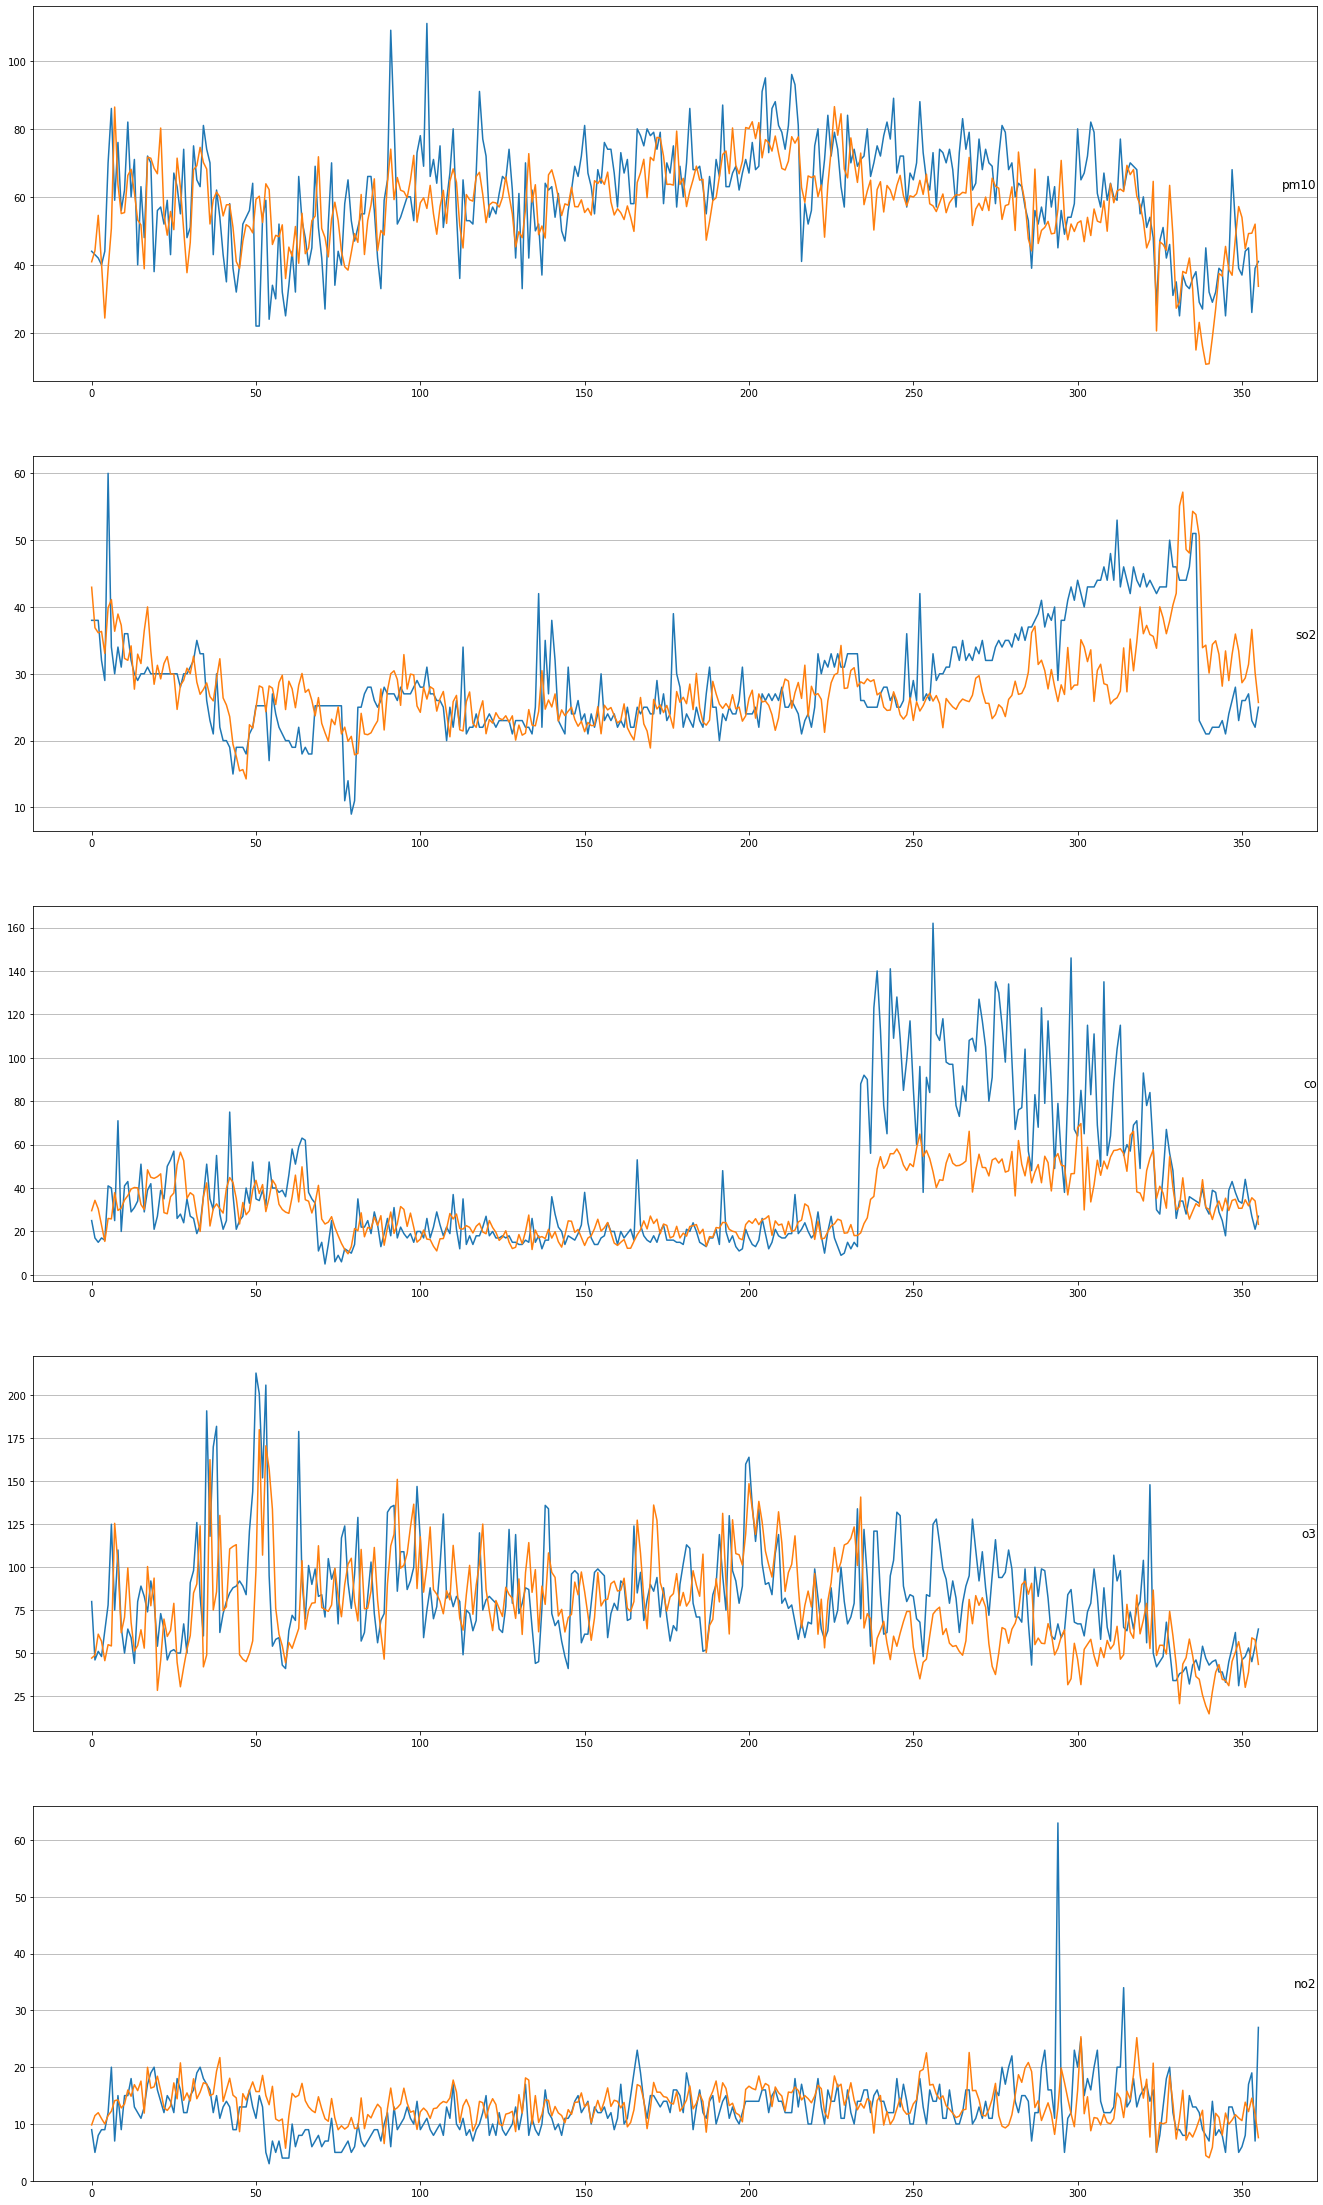

In [13]:
plt.figure(figsize=(23, 40))
for x in range(5):
  
  plt.subplot(5, 1, x+1)
  #plt.yticks(np.arange(0, 1, 0.1))
  plt.plot(inv_y[:,x])
  plt.plot(inv_yhat[:,x])
  plt.grid(axis='y', linestyle='-')
  #plt.ylim([0, 1])
  plt.title(dataset.columns[x+5], y=0.5, loc='right')

plt.show()


## **6. Optimize Model**
it can be seen that the rmse obtained is not good enough, so we try to optimize the model based on: 
https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/2626165/no.ntnu:inspera:2554195.pdf?isAllowed=y&sequence=1

So we build model to predict one by one pollutantinstead of 5 pollutant at the same time using:
1. GRU layer
2. learning_rate = 1e-4 or 5e-5 based on what gas to predict.
3. Number of layer = 2
4. Activation function = LeakyReLU
5. Optimizer = Adam
6. Dropout = 0.2

In [20]:
prev_acc = {"pm10": 13.536, "no2":5.298, "so2":6.808 ,"o3":32.352 ,"co":26.504}

In [23]:
# specify the number of lag days
param = {"pm10":[-1,-2,-3,-4, -6, -7, -8,-9,-10], 
         "so2":[-1,-2,-3,-5, -6, -7, -8,-9,-10], 
         "co":[-1,-2,-4,-5, -6, -7, -8,-9,-10], 
         "o3":[-1, -3,-4,-5, -6, -7, -8,-9,-10],
         "no2":[-2,-3,-4,-5, -6, -7, -8,-9,-10]}
gas_name = input("Gas to predict: ")
n_days = 7
n_features = 10
# frame as supervised learning
df = dataset[[gas_name]]
num = df.values
# ensure all data is float
num = num.astype('float32')
# normalize features
scale = RobustScaler()
scale = scale.fit(num)
result = scale.transform(num)

reframed = series_to_supervised(scaled, n_days, 1)
reframed.drop(reframed.columns[param[gas_name]], axis=1, inplace=True)
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_days = 365*10 
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1:]
test_X, test_y = test[:, :n_obs], test[:, -1:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
reframed.head()

# design network
model = Sequential()
model.add(Bidirectional(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)))
model.add(LeakyReLU(alpha=0.02))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(LeakyReLU(alpha=0.02))
model.add(Dense(1))

optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mae', optimizer="adam")
# fit network
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), shuffle=False)

Gas to predict: pm10
(4006, 71)
(3650, 70) 3650 (3650, 1)
(3650, 7, 10) (3650, 1) (356, 7, 10) (356, 1)
Epoch 1/100
115/115 [==============================] - 11s 26ms/step - loss: 0.6022 - val_loss: 0.4356
Epoch 2/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4836 - val_loss: 0.4404
Epoch 3/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4829 - val_loss: 0.4333
Epoch 4/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4747 - val_loss: 0.4525
Epoch 5/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4622 - val_loss: 0.4636
Epoch 6/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4662 - val_loss: 0.4223
Epoch 7/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4635 - val_loss: 0.4380
Epoch 8/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4799 - val_loss: 0.4570
Epoch 9/100
115/115 [==============================] - 1s 12ms/step - loss: 0.4

Calculate the rmse and save the model if the current rmse less than the previous rmse.

In [26]:
yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = scale.inverse_transform(yhat)

# invert scaling for actual
inv_y = scale.inverse_transform(test_y)

rmse = sqrt(mean_squared_error(inv_yhat, inv_y))
print(f'Test {gas_name} RMSE: %.3f' % rmse)
if rmse<prev_acc[gas_name]:
  model.save(f"/content/gdrive/MyDrive/Model/{gas_name} acc {round(rmse, 3)}.h5")
  prev_acc[gas_name]= round(rmse, 3)

Test pm10 RMSE: 12.204


It can be seen the result is a bit better if we predict one gas.

## **7. Result**
After several experiments with different hyperparameter, we got results as follows:
* pm10: 11.8
* so2: 4.404
* no2: 4.811
* co: 24.741
* o3: 27.804

The hyperparameters used for each gas:
1. pm10:
  * rnn layers : GRU
  * units : 1024
  * activation : LeakyReLU
  * learning_rate : 1e-4
  * Dropout : 0.2

2. so2:
  * rnn layers : LSTM
  * units : 512
  * activation : LeakyReLU
  * learning_rate : 1e-4
  * Dropout : 0.2

3. co:
  * rnn layers : GRU and LSTM
  * units : 512
  * activation : LeakyReLU
  * learning_rate : 5e-5
  * Dropout : 0.2

4. o3:
  * rnn layers : GRU and LSTM
  * units : 512
  * activation : LeakyReLU
  * learning_rate : 5e-5
  * Dropout : 0.2

5. no2:
  * rnn layers : LSTM
  * units : 512
  * activation : LeakyReLU
  * learning_rate : 1e-4
  * Dropout : 0.2


In [28]:
prev_acc

{'co': 24.741, 'no2': 4.811, 'o3': 27.804, 'pm10': 11.8, 'so2': 4.404}

## **8. Export scaler and encoder**

In [29]:
import joblib

for x in param.keys():
  df = dataset[[x]]
  num = df.values
  # ensure all data is float
  num = num.astype('float32')
  # normalize features
  scale = RobustScaler()
  scale = scale.fit(num)
  joblib.dump(scale, f'{x} scaler.gz')
  #my_scaler = joblib.load('scaler.gz')

In [36]:
# load dataset
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = RobustScaler()
scaler = scaler.fit(values)
scaled = scaler.transform(values)
joblib.dump(scaler, f'all scaler.gz')

['all scaler.gz']

In [72]:
joblib.dump(encoder, f'wind encoder.gz')

['wind encoder.gz']